In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Arizona
state_ab = "az"

## Data
1. Download all the data in directory "az_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/Approved_Official_Congressional_Map.shp".format(data_folder, state_ab)
send_data = "./{}{}_sl_adopted_2022/Approved_Official_Legislative_Map.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [11]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [12]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [16]:
maup.doctor(population_df)

100%|█████████████████████████████████| 155444/155444 [00:58<00:00, 2669.06it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [20]:
maup.doctor(county_df)

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.30it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [21]:
vest20 = gpd.read_file(vest20_data)

In [22]:
vest20.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS', 'geometry'],
      dtype='object')

In [23]:
start_col = 3
vest_base_data = vest20
year = '20'

In [24]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 147.31it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 36.89it/s]


Identifying overlaps...


100%|████████████████████████████████████| 39294/39294 [01:17<00:00, 506.33it/s]


Resolving overlaps and filling gaps...


Gaps to fill in region 5: 100%|███████████████████| 4/4 [00:00<00:00, 18.58it/s]
Gaps to simplify in region 6: 478it [00:14, 33.21it/s]                          
Gaps to simplify in region 10: 100%|██████████| 501/501 [00:33<00:00, 15.06it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 14: 100%|████████████████| 19/19 [00:01<00:00, 10.14it/s]


In [25]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [26]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 1489/1489 [00:00<00:00, 3918.23it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|█████████████████████████████████████| 1489/1489 [00:01<00:00, 1135.64it/s]


In [27]:
maup.doctor(vest_base)

100%|█████████████████████████████████████| 1489/1489 [00:01<00:00, 1151.55it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [28]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 1489/1489 [00:07<00:00, 206.14it/s]


In [29]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [30]:
election_df = gpd.GeoDataFrame(vest_base)

In [31]:
election_df.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCTNA',
       'USS20D', 'USS20R', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [32]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [33]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [34]:
vest18.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G18USSRMCS', 'G18USSDSIN',
       'G18USSGGRE', 'G18USSOWRI', 'G18GOVRDUC', 'G18GOVDGAR', 'G18GOVGTOR',
       'G18GOVOWRI', 'G18SOSRGAY', 'G18SOSDHOB', 'G18SOSOWRI', 'G18ATGRBRN',
       'G18ATGDCON', 'G18ATGOWRI', 'G18TRERYEE', 'G18TREDMAN', 'G18TREOWRI',
       'G18SPIRRIG', 'G18SPIDHOF', 'G18SPIOWRI', 'G18MNIRHAR', 'G18MNIDPIE',
       'G18MNIOWRI', 'geometry'],
      dtype='object')

In [35]:
vest16.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI', 'G16USSRMCC', 'G16USSDKIR',
       'G16USSGSWI', 'G16USSOWRI', 'geometry'],
      dtype='object')

In [36]:
# check the result here
start_col = 3
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|█████████████████████████████████████| 1489/1489 [00:01<00:00, 1226.99it/s]


There are 426 overlaps.
There are 5023 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 11803/11803 [00:06<00:00, 1920.94it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 1489/1489 [00:07<00:00, 197.54it/s]


population agrees


In [37]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'CDE_COUNTY', 'GOV18D', 'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'MNI18D', 'MNI18O', 'MNI18R', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PCTNUM', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCTNA', 'SOS18D',
       'SOS18O', 'SOS18R', 'SPI18D', 'SPI18O', 'SPI18R', 'TOTPOP', 'TRE18D',
       'TRE18O', 'TRE18R', 'USS18D', 'USS18O', 'USS18R', 'USS20D', 'USS20R',
       'VAP', 'WVAP', 'geometry'],
      dtype='object')

In [38]:
start_col = 3
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|█████████████████████████████████████| 1469/1469 [00:01<00:00, 1127.45it/s]


There are 271 overlaps.
There are 4805 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 11376/11376 [00:06<00:00, 1777.62it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 1489/1489 [00:07<00:00, 204.84it/s]


population agrees


##  Add the district data

In [43]:
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
cd = gpd.read_file(cd_data)
cd = cd.to_crs(cd.estimate_utm_crs())

In [41]:
send.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV,CompDemVot,CompRepVot,Pres2020_D,Sen2020_DE,...,ST1519_M2_,ST1519_M21,ST1519_M22,ST1519_M23,ST1519_M24,ST1519_M25,G_AINH18,G_AINH18_P,TOTAL18,geometry
0,District 1,D1,1,-159680128,237896,-0.20,36.11,63.89,35.45,36.79,...,186039,9.98,85.74,0.78,2.01,1.26,2473,1.23,200724,"POLYGON ((285554.850 3810172.649, 285555.409 3..."
1,District 2,D2,2,310162560,246674,3.48,48.10,51.90,48.94,50.32,...,169854,15.36,74.95,4.11,1.63,3.71,2186,1.13,192714,"POLYGON ((404435.140 3725995.862, 404577.929 3..."
2,District 3,D3,3,-5635968,236955,-0.60,37.18,62.82,39.19,39.06,...,184570,4.75,89.13,1.47,0.92,3.63,1199,0.61,195367,"POLYGON ((425567.825 3714534.317, 425308.672 3..."
3,District 4,D4,4,-194658649,244298,2.48,48.29,51.71,50.44,50.10,...,188558,8.47,84.26,2.15,0.73,4.17,933,0.46,200823,"POLYGON ((404996.498 3720776.701, 404996.122 3..."
4,District 5,D5,5,-369115520,239088,0.30,69.05,30.95,70.26,70.36,...,163741,25.73,61.15,6.65,3.29,2.85,4313,2.25,192005,"POLYGON ((402626.046 3701825.136, 402512.184 3..."


In [42]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 38.05it/s]


In [44]:
cd.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV,CompDemVot,CompRepVot,Pres2020_D,Sen2020_DE,...,ST1519_M2_,ST1519_M21,ST1519_M22,ST1519_M23,ST1519_M24,ST1519_M25,G_AINH18,G_AINH18_P,TOTAL18,geometry
0,District 1,D1,1,-16777088,794611,0.0,48.70,51.30,50.76,50.76,...,608665,11.28,79.81,3.26,1.93,3.52,9198,1.41,650548,"POLYGON ((409076.007 3703341.375, 409036.796 3..."
1,District 2,D2,2,7405440,794612,0.0,46.40,53.60,45.95,47.33,...,593135,13.68,61.66,2.31,20.70,1.39,115094,18.31,628519,"POLYGON ((496284.359 3702953.079, 496290.960 3..."
2,District 3,D3,3,950534272,794612,0.0,76.46,23.54,75.72,76.71,...,433659,50.55,30.90,12.14,3.11,2.89,11857,2.09,568035,"POLYGON ((397892.926 3710741.278, 397891.373 3..."
3,District 4,D4,4,1275097984,794611,0.0,53.51,46.49,55.25,56.02,...,567091,18.83,68.00,6.10,2.79,3.93,13036,2.07,628965,"POLYGON ((409016.574 3700109.433, 409015.699 3..."
4,District 5,D5,5,-5635968,794612,0.0,40.97,59.02,41.74,42.76,...,502662,14.36,75.95,3.56,1.26,4.63,4349,0.74,584092,"POLYGON ((416888.487 3684040.416, 417011.589 3..."


In [45]:
election_df = add_district(cd, "CD", election_df, "DISTRICT")

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 21.09it/s]


In [46]:
maup.doctor(election_df)

100%|█████████████████████████████████████| 1489/1489 [00:01<00:00, 1122.91it/s]


True

### Put the base precinct year after the precinct information column

In [51]:
base_columns = {}
if 'CDE_COUNTY' + year not in election_df.columns:
    base_columns = {
        'CDE_COUNTY':'CDE_COUNTY'+year,
        'PCTNUM':'PCTNUM'+year,
        'PRECINCTNA':'PRECINCTNA'+year,
    }
election_df.rename(columns=base_columns, inplace = True)

In [52]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18O', 'ATG18R', 'BVAP',
       'CDE_COUNTY20', 'GOV18D', 'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'MNI18D', 'MNI18O', 'MNI18R', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PCTNUM20', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCTNA20', 'SOS18D', 'SOS18O', 'SOS18R', 'SPI18D', 'SPI18O',
       'SPI18R', 'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS16D', 'USS16O',
       'USS16R', 'USS18D', 'USS18O', 'USS18R', 'USS20D', 'USS20R', 'VAP',
       'WVAP', 'geometry', 'SEND', 'CD'],
      dtype='object')

In [53]:
# reorder the columns
fixed_columns = [
    'CDE_COUNTY'+year,
    'PCTNUM'+year,
    'PRECINCTNA'+year,
    'CD',
    'SEND',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [54]:
import os

# store the result in directory "az"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

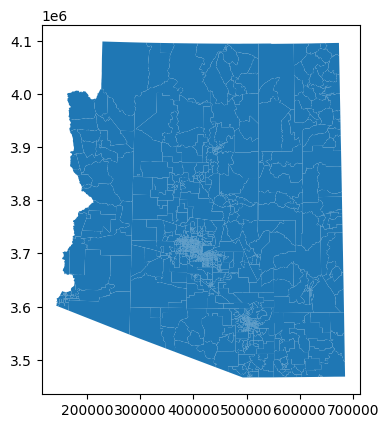

In [55]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()